## <span style="color:#0b486b">Part 1: Deep Feedforward Neural Network </span>

In [1]:
# Create necessary subfolders to store immediate files
import os
if not os.path.exists("./models/dnn0"):
    os.makedirs("models/dnn0")

In [2]:
import numpy as np
import scipy.io as sio
data = sio.matlab.loadmat("~/data/notMNIST_small.mat")
x, y = data['images'], data['labels']
x = np.rollaxis(x, axis=2)
y = y.astype(int)

In [3]:
print("Images and shape = ", data['images'].shape, "\n\nUnique labels = ", set(data['labels']), "\n\nTotal No. of data points = ", data['labels'].shape)

Images and shape =  (28, 28, 18724) 

Unique labels =  {0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0} 

Total No. of data points =  (18724,)


In [4]:
# this function is a utility to display images from the dataset
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def display_images(images, shape):
    fig = plt.figure(figsize=shape)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)
    for i in range(np.prod(shape)):
        p = fig.add_subplot(shape[0], shape[1], i+1, xticks=[], yticks=[])
        p.imshow(images[i], cmap=plt.cm.bone)                

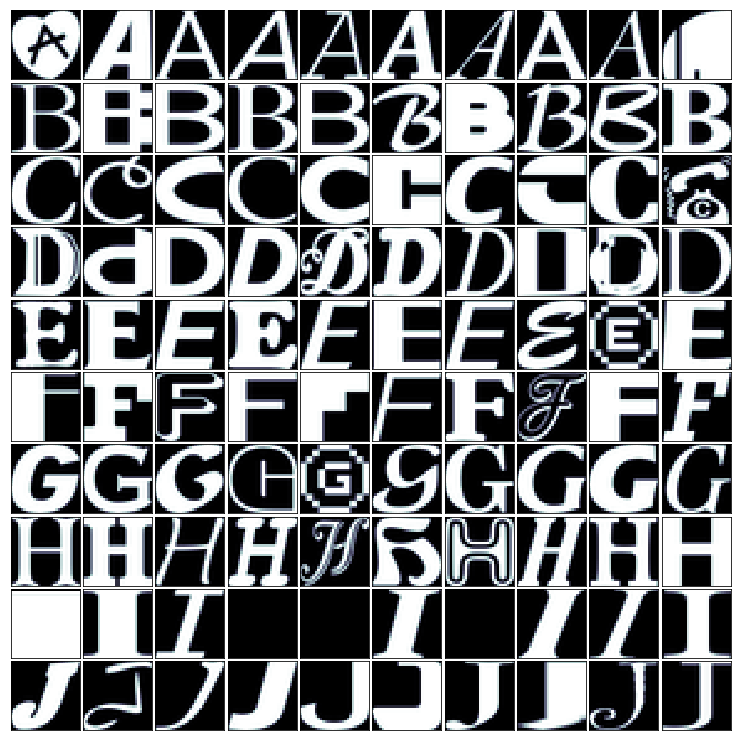

In [5]:
unique_labels = set(data['labels'])
images = []
for l in unique_labels:    
    idx = np.where(y == l)[0]
    idx = idx[np.random.permutation(len(idx))[:10]]    
    for i in idx:
        images.append(x[i])

display_images(images, shape=(10, 10))

In [6]:
reshaped_x = x.reshape((len(x),28 * 28))

In [7]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler() # use the min/max scaler to range [0,1]
reshaped_scaled_x = min_max_scaler.fit_transform(reshaped_x)

In [8]:
# confirm new shape
reshaped_scaled_x.shape

(18724, 784)

In [9]:
# confirm scaling
print("Min: ", min(reshaped_scaled_x[1]), "\nMax: ", max(reshaped_scaled_x[1]))

Min:  0.0 
Max:  1.0


In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

#def generate_batch_data(batch_size, inputs, labels):
# split into a training and testing set
sss = StratifiedShuffleSplit(train_size=0.7, test_size=0.3)
sss.get_n_splits(reshaped_scaled_x,y)

for train_index, test_index in sss.split(reshaped_scaled_x,y): # should return x = 128 x 784, y = 128 x 1
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = reshaped_scaled_x[train_index], reshaped_scaled_x[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(f"\nNumber of training samples:\t{len(x_train)}")
print(f"Number of testing samples:\t{len(x_test)}")

TRAIN: [10801 12983 10104 ...  6880 11109  8063] TEST: [ 8325  2134 10558 ... 18647 17432  1383]
TRAIN: [13436  4005   876 ...   789  2396 13602] TEST: [ 6988 18516  7556 ...  9972 15009  6319]
TRAIN: [ 7763   247  4616 ... 12678 11694 10689] TEST: [17417  9277 15910 ...  4764 12281  7723]
TRAIN: [11721   535  3285 ...   770  1586 13008] TEST: [18722 11505  7934 ... 18212  9639  7602]
TRAIN: [ 5278 17889 13207 ... 12112 18497 14279] TEST: [16640 12247  8877 ... 12143  6990  2932]
TRAIN: [ 8663 14874  3851 ...  2037  7672 18502] TEST: [13752 10558  1185 ... 18445 14608 15388]
TRAIN: [  515 11078 10293 ... 17043 17345  3203] TEST: [ 6491 16146 12386 ...  1841 15377  6757]
TRAIN: [ 1849  6087 11733 ... 13244   612  8213] TEST: [ 1643 16523 15706 ...  9044 13574 16368]
TRAIN: [ 3535    81 12813 ... 10085  5125 13443] TEST: [ 5561 12038  4358 ... 14630  8708 11515]
TRAIN: [13639 18611 12469 ...  6129 16804  5343] TEST: [6780 1505 4542 ...  486 6286 7906]

Number of training samples:	13106
N

In [12]:
import tensorflow as tf
tf.reset_default_graph()

num_inputs = 28 * 28
num_hidden1 = 500
num_hidden2 = 500
num_outputs = len(np.unique(y))
batch_size = 128
learning_rate = 0.0011

inputs = tf.placeholder(tf.float32, shape=[None, num_inputs], name="inputs")
labels = tf.placeholder(tf.int64, shape=[None], name="labels")

In [13]:
def neuron_layer(x, num_neurons, name, activation=None):
    with tf.name_scope(name):
        num_inputs = int(x.get_shape()[1])
        stddev = 2 / np.sqrt(num_inputs)
        init = tf.truncated_normal([num_inputs, num_neurons], stddev=stddev)
        W = tf.Variable(init, name="weights")
        b = tf.Variable(tf.zeros([num_neurons]), name="biases")
        z = tf.matmul(x, W) + b
    if activation == "sigmoid":
        return tf.nn.sigmoid(z)
    elif activation == "relu":
        return tf.nn.relu(z)
    else:
        return z

In [14]:
x = tf.placeholder(tf.float32, shape=(None, num_inputs), name="x")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = neuron_layer(x, num_hidden1, "hidden1", activation="relu")
    hidden2 = neuron_layer(hidden1, num_hidden2, "hidden2", activation="relu")
    logits = neuron_layer(hidden2, num_outputs, "output")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("evaluation"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,\
                                                             logits=logits, name="xentropy")
    loss = tf.reduce_mean(xentropy, name="loss")
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    grads = optimizer.compute_gradients(loss)  
    training_op = optimizer.minimize(loss)
        
    for var in tf.trainable_variables():
        tf.summary.histogram(var.op.name + "/values", var)
        
    for grad, var in grads:
        if grad is not None:
            tf.summary.histogram(var.op.name + "/gradients", grad)

# summary
accuracy_summary = tf.summary.scalar('accuracy', accuracy)


In [15]:
# merge all summary
tf.summary.histogram('hidden1/activations', hidden1)
tf.summary.histogram('hidden2/activations', hidden2)
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()
saver = tf.train.Saver()

train_writer = tf.summary.FileWriter("models/dnn0/train", tf.get_default_graph())
test_writer = tf.summary.FileWriter("models/dnn0/test", tf.get_default_graph())

num_epochs = 50
batch_size = 128

In [17]:
with tf.Session() as sess:
    init.run()
    print("Epoch\tTrain accuracy\tTest accuracy")
    for epoch in range(num_epochs):
        for idx_start in range(0, x_train.shape[0], batch_size):
            idx_end = idx_start + batch_size
            # shuffle data whilst retaining relationships and copy across mini batches of batch_size
            x_batch, y_batch = x_train[idx_start:idx_end],y_train[idx_start:idx_end]
            sess.run(training_op, feed_dict={inputs: x_batch, labels: y_batch, x: x_train, y: y_train})
            
        summary_train, acc_train = sess.run([merged, accuracy],
                                             feed_dict={x: x_batch, y: y_batch})
        summary_test, acc_test = sess.run([accuracy_summary, accuracy],
                                          feed_dict={x: x_train, y: y_train})
        
        train_writer.add_summary(summary_train, epoch)
        test_writer.add_summary(summary_test, epoch)
        
        print("{}\t{}\t{}".format(epoch, acc_train, acc_test))

    save_path = saver.save(sess, "models/dnn0.ckpt")

Epoch	Train accuracy	Test accuracy
0	0.5199999809265137	0.5267053246498108
1	0.7799999713897705	0.7121165990829468
2	0.8399999737739563	0.7723942995071411
3	0.8399999737739563	0.8005493879318237
4	0.8600000143051147	0.8161910772323608
5	0.8799999952316284	0.827636182308197
6	0.8799999952316284	0.8348084688186646
7	0.8799999952316284	0.8412940502166748
8	0.8799999952316284	0.8457958102226257
9	0.8799999952316284	0.8485426306724548
10	0.8799999952316284	0.8525102734565735
11	0.8999999761581421	0.8562490344047546
12	0.8999999761581421	0.8589958548545837
13	0.9200000166893005	0.8614374995231628
14	0.9200000166893005	0.8636502623558044
15	0.9200000166893005	0.8658629655838013
16	0.9200000166893005	0.8670837879180908
17	0.9399999976158142	0.8686860799789429
18	0.9399999976158142	0.8696780204772949
19	0.9399999976158142	0.870975136756897
20	0.9399999976158142	0.8720433115959167
21	0.9399999976158142	0.8728063702583313
22	0.9399999976158142	0.8742560744285583
23	0.9399999976158142	0.8760873079

---

## <span style="color:#0b486b">Part 2: Word2Vec, Text Analytics and Application</span>

In [1]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers'))

In [2]:
print("Unique Labels: ", list(newsgroups_all.target_names), "\n\nKeys:", list(newsgroups_all.keys()), "\n\nNumber of documents: ", len(newsgroups_all['data']))

Unique Labels:  ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc'] 

Keys: ['data', 'filenames', 'target_names', 'target', 'DESCR', 'description'] 

Number of documents:  18846


In [3]:
import gensim
from gensim.utils import tokenize

for i in range(0, len(newsgroups_all.data)):
    newsgroups_all.data[i] = list(tokenize(newsgroups_all.data[i]))

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [4]:
from gensim.models import Word2Vec
import time
sg_ = 1 # the training algorithm. If sg=0, CBOW is used. Otherwise (sg=1), skip-gram is employed.
alg = 'CBOW' if sg_ == 0 else 'sg'
size_ = 100 #  the dimensionality of the feature vectors
window_ = 5 # the context size or the maximum distance between the current and predicted word
min_count_ = 5
sentences =  newsgroups_all['data']

# where to save the model learned
model_file = '~/data/' + alg + '_' + str(size_) + '_' + str(window_)

# keep the time starting the training
start_time = time.time()
print("Running ...")

# training embedded vectors for the dataset with the parameters specified above
model = Word2Vec(sentences, sg = sg_, size = size_, window = window_, min_count = min_count_ )
# save the model learned into model file
model.save(model_file)
                 
# show how long does it take to train the word vectors
print("="*40)
runtime = time.time() - start_time
print("--- Running time: %s seconds ---" % (runtime))
words = list(model.wv.vocab.keys())
print(f"The number of words: {len(words)}")

Running ...
--- Running time: 55.51814842224121 seconds ---
The number of words: 42461


* Save the trained model to a file named "20_newsgroups.gensim"

In [5]:
model.save('~/data/20_newsgroups.gensim')

In [6]:
words = list(model.wv.vocab.keys())
print(f"The number of words: {len(words)}")

The number of words: 42461


In [7]:
from gensim.models import Word2Vec
import numpy as np
from numpy import dot
from numpy.linalg import norm

# compute cosine similarity for two vector u & v
def cosine_similarity(u, v):
    return dot(u, v)/(norm(u)*norm(v))

# compute cosine similarity for vector v & all vectors in matrix W
def cosine_similarity_matrix(W, v):
    return dot(W, v)/(norm(W, axis=1)*norm(v))

# word vectors from the model in the order of words
W = np.asarray([model[word] for word in words])

# what is the word closest to a given word?
word = 'law'

# vector of the word
v = model[word]
# its similarity to all of other vectors
sim = cosine_similarity_matrix(W, v)
# set the similar to its own zero as we do not want to see the word in the list
sim[words.index(word)] = 0
# indices of words whose the similarity from smallest to largest
indices = sim.argsort()
# reverse the order, then indices of words whose the similarity from largest to smallest
indices = indices[::-1]
# how many words you want
TOP = 10 
indices = indices[:TOP]
# turn indices into words and their respective similarity to the word
top_words = [(words[i], sim[i]) for i in indices]
print("The top ten words similar to \'{}\'".format(word))
top_words

The top ten words similar to 'law'


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


[('enforcement', 0.8355416),
 ('abiding', 0.7553583),
 ('laws', 0.7255633),
 ('giveth', 0.7047948),
 ('fasad', 0.683659),
 ('Constitutional', 0.68217933),
 ('Enforcement', 0.67896086),
 ('lawfully', 0.67592174),
 ('violating', 0.6662756),
 ('protects', 0.6657257)]

In [9]:
def extract_doc2vec(doc, w2v):
    vecs = [w2v[word] for word in doc if word in w2v]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).sum(axis=0)
    return vecs

documents = []
x = []
y = []
x_inner = []
start_time = time.time()
print("Running ...")
for i in range(0, len(newsgroups_all['data'])):
    if len(newsgroups_all['data'][i]) == 0:
        documents.append(i)
    else:
        #for j in range(0, len(newsgroups_all['data'][i])):
        #    x_inner.append(extract_doc2vec(gensim.utils.simple_preprocess(newsgroups_all['data'][i][j]),model)) # collect word vectors
        #x.append(x_inner) # put all word vectors into each document as document vectors
        x.append(extract_doc2vec(newsgroups_all['data'][i],model))
        y.append(newsgroups_all['target'][i]) # store corresponding labels
            
runtime = time.time() - start_time
print("--- Running time: %s seconds ---" % (runtime))
print("Count of empty documents:", len(documents), "\n\nEmpty documents:",documents)

Running ...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


--- Running time: 29.914812803268433 seconds ---
Count of empty documents: 35 

Empty documents: [185, 984, 1330, 1454, 3271, 3918, 4032, 5069, 5215, 5277, 5308, 6011, 6827, 7016, 7340, 8088, 8707, 10697, 10877, 11063, 12391, 12788, 12856, 12980, 13779, 13911, 14607, 14735, 14924, 15145, 16025, 16653, 16667, 17117, 17346]


In [10]:
# convert lists to dataframes and pull numpy arrays out.
import pandas as pd
x = pd.DataFrame(x).values
y = pd.DataFrame(y).values

In [11]:
# logistic regression was failing due to NaN values. Check which arrays may have not been picked up.
np.where(np.isnan(x))

(array([15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639, 15639,
        15639, 18116, 18116, 18116, 18116, 18116, 18116, 18116, 18116,
        18116, 18116, 18116, 18116, 18116, 18116, 18116, 18116, 18116,
        18116, 18116, 18116, 18116, 18116, 18116, 18116, 18116, 18116,
      

In [12]:
x = pd.DataFrame(x)
y = pd.DataFrame(y)

In [13]:
a = x.drop([15639,18116])
b = y.drop([15639,18116])
print('x:', np.where(np.isnan(a.values)),
     '\ny:', np.where(np.isnan(b.values)))

x: (array([], dtype=int64), array([], dtype=int64)) 
y: (array([], dtype=int64), array([], dtype=int64))


In [14]:
x = a.values
y = b.values

In [15]:
# confirm new x and y are missing empty documents
print("Document original length: ", len(newsgroups_all['data']),
     "\n\nX length:", len(x),
     "\n\nY length:", len(y))

Document original length:  18846 

X length: 18809 

Y length: 18809


In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

# split into a training and testing set
sss = StratifiedShuffleSplit(train_size=0.7, test_size=0.3)
sss.get_n_splits(x,y)

for train_index, test_index in sss.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(f"\nNumber of training samples:\t{len(x_train)}")
print(f"Number of testing samples:\t{len(x_test)}")

TRAIN: [ 8187  8065  6002 ... 13381 18575 15733] TEST: [11706  5630 16630 ...  7091   508  9176]
TRAIN: [17274  7683  4585 ... 11235 18274   617] TEST: [12398 12265  5575 ...  1740  8519 14702]
TRAIN: [15326  4528 10187 ...  4658  2415 12146] TEST: [16634 11001  2217 ... 14014 11263 17255]
TRAIN: [17835 18616 18708 ... 13197  3591 18490] TEST: [ 7882 12734 12933 ...  5359  4364 18709]
TRAIN: [17022 11066  3382 ...  3682 18235   941] TEST: [14109  6834 11746 ...  2693  8274  1428]
TRAIN: [ 5721 11084  3673 ...   738  7831 11650] TEST: [ 8530 11200  7746 ...  7548 13937  4159]
TRAIN: [ 9941  4312  4638 ...    78 10928  8488] TEST: [ 6641  1503 11118 ...  1661 13338 18407]
TRAIN: [ 4986 16756  5828 ... 15986 16829 17969] TEST: [ 2226  7374  5773 ... 13756  7336  3518]
TRAIN: [ 5136  9175 17238 ...  8687 17623   813] TEST: [13342  8245 15052 ...   810 12851 11434]
TRAIN: [ 2813  1323  7850 ... 10206  6007  7973] TEST: [ 1094  1175 15107 ... 15675  1103  6069]

Number of training samples:	1

In [17]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

# fit the model
LR.fit(x_train, y_train)

# predict the training results
results = LR.predict(x_train)

# predict the testing results
results_test = LR.predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("\nLogistic Regression Training Results\nAccuracy = \t", accuracy_score(y_train, results), 
      "\nRecall = \t", recall_score(y_train, results, average='macro'), # looking for unweighted mean
      "\nPrecision = \t", precision_score(y_train, results, average='macro'),
      "\nF-score = \t", f1_score(y_train, results, average='macro'))

print("\nLogistic Regression Testing Results\nAccuracy = \t", accuracy_score(y_test, results_test), 
      "\nRecall = \t", recall_score(y_test, results_test, average='macro'), # looking for unweighted mean
      "\nPrecision = \t", precision_score(y_test, results_test, average='macro'),
      "\nF-score = \t", f1_score(y_test, results_test, average='macro'))


Logistic Regression Training Results
Accuracy = 	 0.6985416983138387 
Recall = 	 0.6913066434784759 
Precision = 	 0.7006673959274725 
F-score = 	 0.6919441546654227

Logistic Regression Testing Results
Accuracy = 	 0.6671982987772461 
Recall = 	 0.6578729670937405 
Precision = 	 0.6649437408255512 
F-score = 	 0.6580370123314874


In [19]:
# re-import data to ensure it is unaltered
newsgroups_all = fetch_20newsgroups(subset='all', remove=('headers'))

# usel altered model with "average"
def extract_doc2vec(doc, w2v):
    vecs = [w2v[word] for word in doc if word in w2v]
    if len(vecs) > 0:
        vecs = np.asarray(vecs).mean(axis=0)
    return vecs

documents = []
x = []
y = []
x_inner = []
start_time = time.time()
print("Running ...")
for i in range(0, len(newsgroups_all['data'])):
    if len(newsgroups_all['data'][i]) == 0:
        documents.append(i)
    else:
        #for j in range(0, len(newsgroups_all['data'][i])):
        #    x_inner.append(extract_doc2vec(gensim.utils.simple_preprocess(newsgroups_all['data'][i][j]),model)) # collect word vectors
        #x.append(x_inner) # put all word vectors into each document as document vectors
        x.append(extract_doc2vec(newsgroups_all['data'][i],model))
        y.append(newsgroups_all['target'][i]) # store corresponding labels
            
runtime = time.time() - start_time
print("--- Running time: %s seconds ---" % (runtime))
print("Count of empty documents:", len(documents), "\n\nEmpty documents:",documents)

Running ...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


--- Running time: 146.48105216026306 seconds ---
Count of empty documents: 6 

Empty documents: [185, 12391, 12788, 12980, 16667, 17346]


In [20]:
# convert lists to dataframes and pull numpy arrays out.
import pandas as pd
x = pd.DataFrame(x).values
y = pd.DataFrame(y).values

# check for NaNs that may have gotten through
a = np.where(np.isnan(x))
print(a)

(array([  983,   983,   983, ..., 17112, 17112, 17112], dtype=int64), array([ 0,  1,  2, ..., 97, 98, 99], dtype=int64))


In [21]:
a[0]

array([  983,   983,   983, ..., 17112, 17112, 17112], dtype=int64)

In [22]:
# set as DataFrames for "drop"
x = pd.DataFrame(x)
y = pd.DataFrame(y)

# drop and confirm
c = x.drop(a[0])
d = y.drop(a[0])
print('x:', np.where(np.isnan(c.values)),
     '\ny:', np.where(np.isnan(d.values)))

x: (array([], dtype=int64), array([], dtype=int64)) 
y: (array([], dtype=int64), array([], dtype=int64))


In [23]:
# convert lists to dataframes and pull numpy arrays out.
import pandas as pd
x = pd.DataFrame(c).values
y = pd.DataFrame(d).values

### repurposed code from 1.4b
from sklearn.model_selection import StratifiedShuffleSplit

# split into a training and testing set
sss = StratifiedShuffleSplit(train_size=0.7, test_size=0.3)
sss.get_n_splits(x,y)

for train_index, test_index in sss.split(x,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

print(f"\nNumber of training samples:\t{len(x_train)}")
print(f"Number of testing samples:\t{len(x_test)}")

TRAIN: [10849 15397  5092 ... 13755   122 14387] TEST: [14019  3669 12666 ... 15393  3012 17452]
TRAIN: [ 1822  9430  5943 ...  3501 11971 16775] TEST: [15700  2955 13531 ...  6743 16589 17975]
TRAIN: [10024  7246 12053 ... 14212  1549  7262] TEST: [ 4414  8774 17315 ...  1041 14577  9766]
TRAIN: [ 9107  6460  5101 ...  8398  6493 15234] TEST: [ 3232  7580 14507 ...  6667 14426  8074]
TRAIN: [ 9873   819 17027 ...  2016 17139  6984] TEST: [ 3674  9911   825 ... 12166  4480  7810]
TRAIN: [  614  7374  1330 ...  5200 14801  5316] TEST: [ 2663  4578 15941 ... 13614  1066   893]
TRAIN: [ 9216  8479 14504 ... 13681  4372  5076] TEST: [ 2646  8940  9004 ... 10850 15244 16241]
TRAIN: [12794  8000  9884 ... 12322  7870 11675] TEST: [13700  3369 11590 ...  3866  8780 10834]
TRAIN: [ 8901 15753  9401 ... 11155 16337 12684] TEST: [ 9080 16313 12957 ... 15186 17858 14953]
TRAIN: [14939  4406  9692 ... 17611 18621  1973] TEST: [ 5273 10697  3790 ...  2087  9425 14008]

Number of training samples:	1

In [24]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

# fit the model
LR.fit(x_train, y_train)

# predict the training results
results = LR.predict(x_train)

# predict the testing results
results_test = LR.predict(x_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [25]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("\nLogistic Regression Training Results\nAccuracy = \t", accuracy_score(y_train, results), 
      "\nRecall = \t", recall_score(y_train, results, average='macro'), # looking for unweighted mean
      "\nPrecision = \t", precision_score(y_train, results, average='macro'),
      "\nF-score = \t", f1_score(y_train, results, average='macro'))

print("\nLogistic Regression Testing Results\nAccuracy = \t", accuracy_score(y_test, results_test), 
      "\nRecall = \t", recall_score(y_test, results_test, average='macro'), # looking for unweighted mean
      "\nPrecision = \t", precision_score(y_test, results_test, average='macro'),
      "\nF-score = \t", f1_score(y_test, results_test, average='macro'))


Logistic Regression Training Results
Accuracy = 	 0.25009493430546065 
Recall = 	 0.2400697204152587 
Precision = 	 0.2334760502520122 
F-score = 	 0.20839149817137304

Logistic Regression Testing Results
Accuracy = 	 0.24433026222537207 
Recall = 	 0.23415976503955407 
Precision = 	 0.219203264100626 
F-score = 	 0.20022804016102022


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


With accuracy around 67-70% for sum doc vector and 24% for average doc vector, it is easy to state that sum of doc vector gives the better performance. This is true across all categories; recall, precision and F-score. 

Neither implementations appear to do well for this model. The assumptions are that each document can be surmised in a 100 vector array, leading to massive variability when dealing with documents of greatly differing lengths. For instance a document with 3 words will have a 100 dimension vector representation as will a document with 1,000 words. This leads to an uneven representation of the documents with some gaining dimensionality and others losing it.

Without trialling other models against the dataset it is difficult to say that logistic regression is the best model to use. Usually there would be a comparison with 2 other models to see what best represents the 100 dimension document vectors.

There was also lack of exploration into the balance of the dataset, with certain words potentially having stronger influence.